In [1]:
# 모듈, 경로 설정
import pandas as pd
import pydeck as pdk
import geopandas as gpda
import config
import json
import requests
import sys
import folium
import warnings

warnings.filterwarnings(action='ignore')

path = "C:\github/aide-analysis/"
sys.path.append(path)

path2 = "C:\github/prop-tech/"
sys.path.append(path2)
from src.bigquery import bigquery_client, bigquery
from src.visualization import Pydeck
pydeck = Pydeck()
bq = bigquery_client
from core.config import Config
config = Config()

from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops

In [2]:
# 시각화 한글패치
import os
import matplotlib.pyplot as plt

if os.name =='posix':

    plt.rc('font', family = 'AppleGothic')

else:

    plt.rc('font', family = 'Malgun Gothic')

In [3]:
from src.sql import DatabaseHandler

db = DatabaseHandler()
sql = f"""
SELECT *
FROM aide.unsold_sigungu
WHERE sidoCode = '28'
"""
sigungu = db.read_table(sql)

In [4]:
# 인천광역시 전체 지표
sido = sigungu[(sigungu['sigunguCode']=='28000') & (sigungu['year']>=2022)]

In [5]:
# 인천광역시 시군구별 지표
sigungu = sigungu[(sigungu['sigunguCode']!='28000') & (sigungu['year']>=2022)]

In [6]:
sigungu['sigunguName'].unique()

array(['중구', '남동구', '서구', '연수구', '미추홀구', '동구', '부평구', '계양구', '강화군', '옹진군'],
      dtype=object)

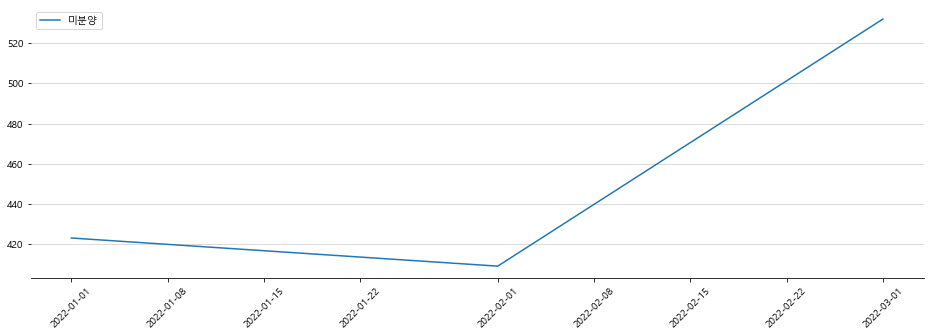

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(sido['date'], sido['unsold'], label = '미분양')

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성



# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
plt.xticks(rotation = '45')
ax.legend()


In [23]:
from src.bigquery import BigqueryHandler
BH = BigqueryHandler()

sql = f"""
SELECT T1.contractYear,T1.contractMonth,AVG(T1.first) AS first, AVG(T1.second) AS second, AVG(T1.third) AS third, AVG(t1.last) AS last
FROM(
    SELECT transaction.contractYear,
           transaction.contractMonth,
           CASE WHEN sub.supplyArea <= 60 THEN AVG(transaction.transactionPrice)END AS first,
            CASE WHEN sub.supplyArea>60 AND sub.supplyArea<=85 THEN AVG(transaction.transactionPrice) END AS second,
            CASE WHEN sub.supplyArea>85 AND sub.supplyArea<=135 THEN AVG(transaction.transactionPrice) END AS third,
            CASE WHEN sub.supplyARea>135 THEN AVG(transaction.transactionPrice) END AS last
    FROM aide.transaction_price_apartment_trading AS transaction
    INNER JOIN (
                SELECT pnuCode, jeonyuArea, supplyArea
                FROM aide.apartment_area_type_information
                WHERE sidoCode = '28'
            ) AS sub
                ON transaction.pnuCode = sub.pnuCode
                AND transaction.jeonyongArea = sub.jeonyuArea

    WHERE transaction.pnuCode LIKE '28%' AND transaction.cancelDate is null AND transaction.contractYear=2022
    GROUP BY transaction.contractYear, transaction.contractMonth, sub.supplyArea
    ORDER BY transaction.contractYear
    )AS T1
GROUP BY T1.contractYear, T1.contractMonth
ORDER BY T1.contractYear, T1.contractMonth
"""
df = BH.read_table(sql)


In [24]:
df

,contractYear,contractMonth,first,second,third,last
0,2022,1,14876.100243,26922.276910,46961.970443,72479.291667
1,2022,2,15461.917637,26867.451420,46767.045455,72410.869565
2,2022,3,15229.763072,26645.841611,47925.603571,79896.408163
3,2022,4,15815.893108,27387.328379,49310.668550,74154.044118
4,2022,5,14423.904321,27749.731456,47892.553333,70201.893939


In [27]:
df['first'] = df['first'].apply(lambda x: (x/df['first'].iloc[0])-1)
df['second'] = df['second'].apply(lambda x: (x/df['second'].iloc[0])-1)
df['third'] = df['third'].apply(lambda x: (x/df['third'].iloc[0])-1)
df['last'] = df['last'].apply(lambda x: (x/df['last'].iloc[0])-1)

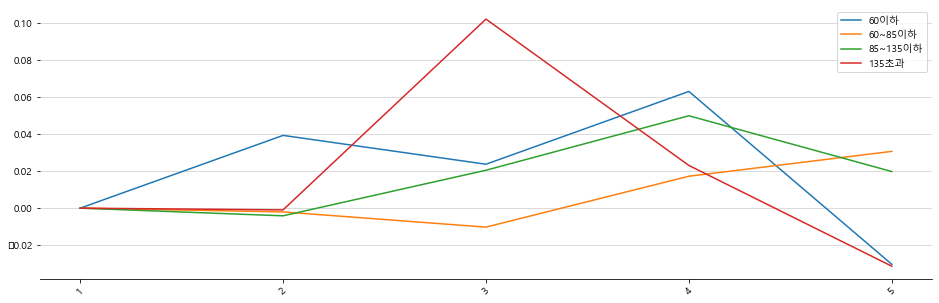

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize = (16, 5))
ax.plot(df['contractMonth'], df['first'], label = '60이하')
ax.plot(df['contractMonth'], df['second'], label = '60~85이하')
ax.plot(df['contractMonth'], df['third'], label= '85~135이하')
ax.plot(df['contractMonth'], df['last'], label = '135초과')

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성



# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
plt.xticks(rotation = '45')
ax.legend()
# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(5)) 